## Deep learning course project
# Military aircraft classification
by Glib Avrutin

# 1. Introduction

The main goal of this project was designing and training neural network to classify planes of 40 classes and benchmarking it's performance with test images

While pondering the project's theme, I aimed for a balance between familiarity with our course material and a touch of something diffirent. Because I'm a huge fan of aviation, the military aircraft satellite image dataset named MTARSI (stands for Muti-type Aircraft of Remote Sensing Images) with 40 classes was my choice, even though it's quality is not the best and it's unbalanced. And of course not every image of 10000 is original, some of them are variations of previous ones with different size, angle, background etc.

Dataset: https://zenodo.org/record/5044950

Dataset on my Google Drive: https://drive.google.com/drive/folders/1cqSVuz-Xt1sAHlZmMR6lp3xatgQq7UzU?usp=drive_link (With test images)

# 1. Install dependencies and mount the drive

In [ ]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from google.colab import drive

I uploaded the whole dataset to my google drive, so if you want to run training by yourself you will have to upload it too (Or connect dataset via link above but i have no idea how to do it)

In [ ]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Data Directory, you'll have to change it if you decide to train network.

In [ ]:
data_dir = '/content/gdrive/MyDrive/Project_DL/MTARSI2'

# 2. Data loader

Here i print out every class in dataset and append it to the list which will be handy in predictions.

In [ ]:
aircraftClass = []
for imgClass in sorted(os.listdir(data_dir)):
  print(imgClass)
  aircraftClass.append(imgClass)

A-10_Thunderbolt
ATR-72_Airliner
ATR_72_ASW
Airliner
B-1_Lancer
B-29_Superfortress
B-2_Spirit
B-52_Stratofortress
B-57_Canberra
BusinessJet
C-130_Hercules
C-135_Stratolifter
C-17_Globemaster
C-295M_CASA_EADS
C-40_Clipper
C-5_Galaxy
DC-4
DC-4E
E-2_Hawkeye
E-3_Sentry
EA-6B_Prowler
F-15_Eagle
F-16_Falcon
F-18_Hornet
F-22_Raptor
F-35_JSF
F-4_Phantom
KC-767_Tanker
King_Air_Beechcraft_Airliner
King_Air_Beechcraft_ISR
LightACHighSetWing
LightACLowSetWing
LightACTwinEnginProp
P-3_Orion
RC-135_Rivit_Joint
Su-35_Flanker
T-1A_Jayhawk_Trainer
T-43A_Boeing737-253A_Trainer
Tu-160_Tupolev_White_Swan
UTA_Fokker_50_Utility_Transport


Now I'm loading the data using Keras' ***image_dataset_from_directory***, which is really powerfull tool. The utility expects your image data to be organized in a directory structure where each subdirectory represents a different class or category. The utility automatically loads images from the subdirectories and assigns labels based on the subdirectory names (class names). It also shuffles the data by default, which helps in training stability. The loaded data is then batched according to the batch size you specify. (I prefer 200). It also allows me to use numpy iterators to manage data and rescales every image to the certain shape. ((256, 256) by default)

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = 200)

Found 10192 files belonging to 40 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

This cell prints out some of the photos and it's classes.

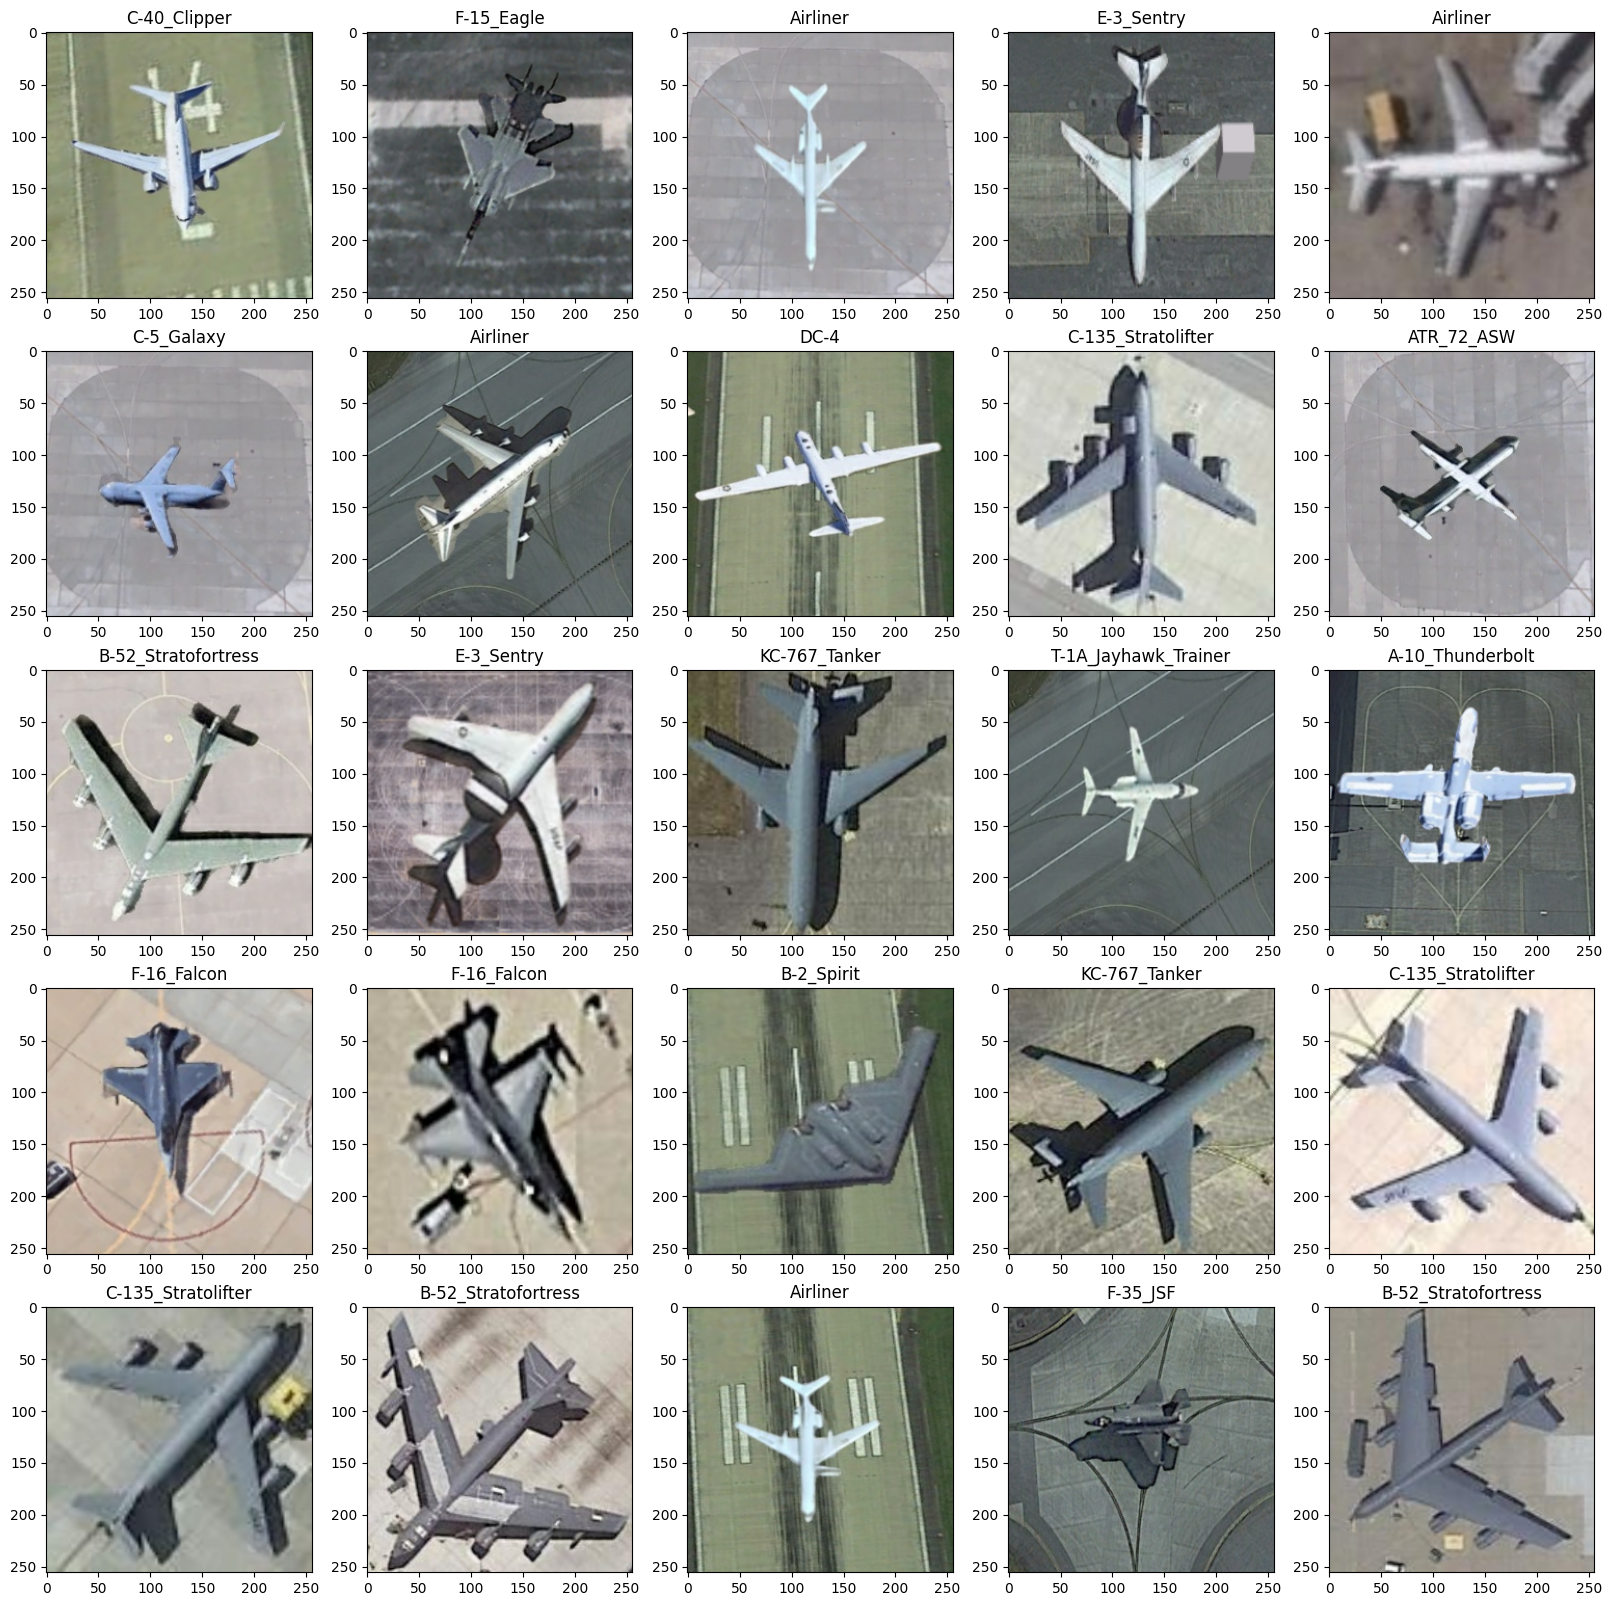

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:25]):
  f = idx // 5
  pl_idx = idx % 5
  ax[f][pl_idx].imshow(img.astype(int))
  ax[f][pl_idx].title.set_text( aircraftClass[ batch[1][idx] ] )

# 3. Preprocessing

Here I normalize pixel values. (0-255) to (0-1). This form of image representation is more preferable in machine learning.

In [ ]:
scalLambda = lambda x,y: (x/255, y)
data = data.map(scalLambda)

Let's take a small peek into the data structure and check if new values are good.

In [ ]:
data.as_numpy_iterator().next()

(array([[[[0.9408701 , 0.92518383, 0.8898897 ],
          [0.83901656, 0.8233303 , 0.78803617],
          [0.7646446 , 0.74895835, 0.71366423],
          ...,
          [0.8117341 , 0.77643996, 0.7568321 ],
          [0.8117647 , 0.77254903, 0.7647059 ],
          [0.80785847, 0.7686428 , 0.76079965]],
 
         [[0.861826  , 0.8461397 , 0.8108456 ],
          [0.78786767, 0.7721814 , 0.7368873 ],
          [0.74911153, 0.73342526, 0.69813114],
          ...,
          [0.80382967, 0.76853555, 0.7489277 ],
          [0.8116728 , 0.7724571 , 0.764614  ],
          [0.81171876, 0.7725031 , 0.76465994]],
 
         [[0.7835478 , 0.76786155, 0.7325674 ],
          [0.75701594, 0.74132967, 0.70603555],
          [0.7573989 , 0.7417126 , 0.7064185 ],
          ...,
          [0.79607844, 0.7607843 , 0.7411765 ],
          [0.803845  , 0.7646293 , 0.75678617],
          [0.80768996, 0.7684743 , 0.76063114]],
 
         ...,
 
         [[0.7883119 , 0.7530178 , 0.75693935],
          [0.78446

Here I split data into train and validation parts.

In [ ]:
train_size = int(len(data)*.8)
val_size = len(data) - train_size

Size of each part (in batches)

In [ ]:
print(train_size)
print(val_size)

40
11


The process of splitting

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

# 4. Model design


Take a look on a shape here

In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Model design.
Three convolutional layers + three dense layers.
Input shape is (256,256).
Dropouts to prevent overfitting

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(40, activation='softmax'))

In [ ]:
model.compile('adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

Model plot

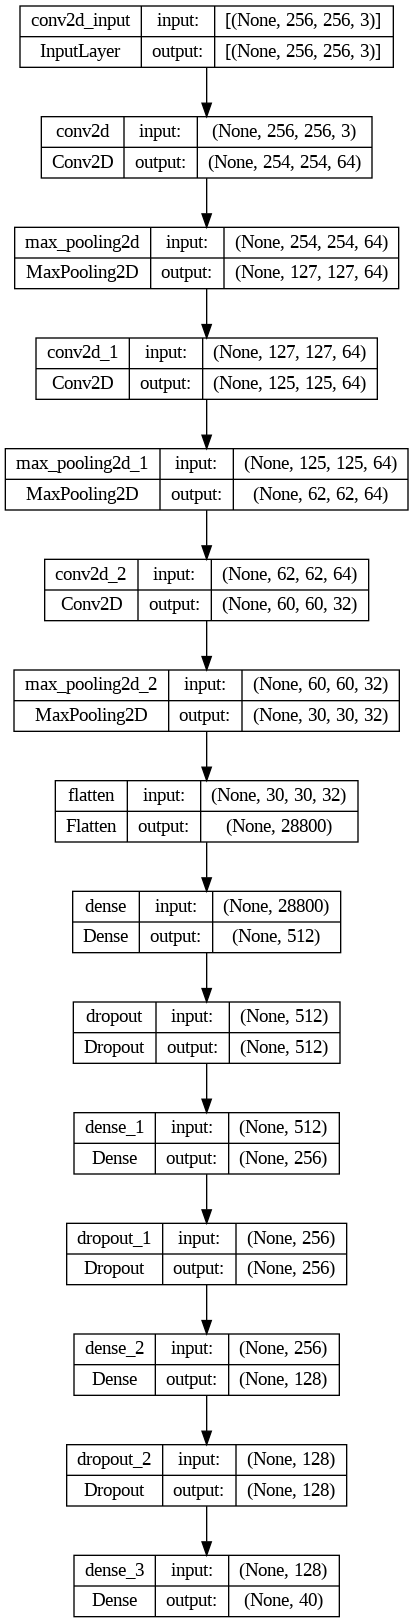

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 5. Fitting

Training process

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

After many fittings I was unable to improve results. Larger networks needed larger amount of RAM, and google colab machine couldn't provide it unless you pay for a subscription...

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
40/40 [==============================] - 89s 2s/step - loss: 3.4700 - accuracy: 0.0707 - val_loss: 3.1955 - val_accuracy: 0.1378
Epoch 2/10
40/40 [==============================] - 60s 1s/step - loss: 2.8380 - accuracy: 0.2272 - val_loss: 2.1518 - val_accuracy: 0.4421
Epoch 3/10
40/40 [==============================] - 63s 2s/step - loss: 1.9561 - accuracy: 0.4608 - val_loss: 1.4443 - val_accuracy: 0.6086
Epoch 4/10
40/40 [==============================] - 59s 1s/step - loss: 1.2785 - accuracy: 0.6348 - val_loss: 1.0193 - val_accuracy: 0.7112
Epoch 5/10
40/40 [==============================] - 70s 2s/step - loss: 0.8416 - accuracy: 0.7498 - val_loss: 0.6614 - val_accuracy: 0.8180
Epoch 6/10
40/40 [==============================] - 59s 1s/step - loss: 0.5747 - accuracy: 0.8254 - val_loss: 0.5570 - val_accuracy: 0.8403
Epoch 7/10
40/40 [==============================] - 58s 1s/step - loss: 0.3843 - accuracy: 0.8767 - val_loss: 0.3996 - val_accuracy: 0.8882
Epoch 8/10
40/40 [==

# 6. Plot Performance

Well, plots look good, but there is a small overfitting in the end which impact is not crucial at all.

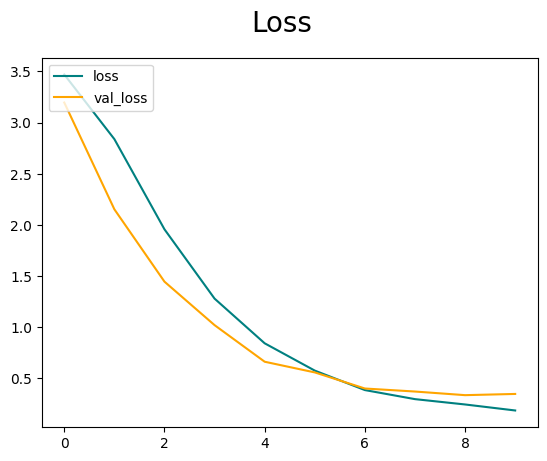

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

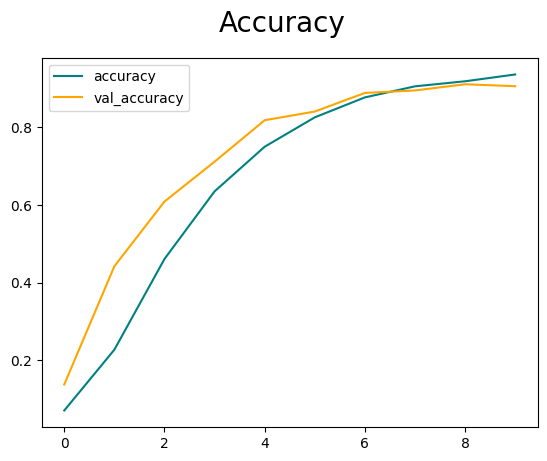

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 7. Predictions

This is a functions which returns a string with prediction. Because predict method returns an array of probabilities, I search for a biggest value and return a class name corresponding to the index of probability value.

In [ ]:
def predictAircraft(aircraftImage, model):
  yHat = model.predict(aircraftImage)
  maxVal = np.max(yHat)
  maxIdx = np.argmax(yHat)
  return "This is a(an) " + aircraftClass[maxIdx] + ", probability is " + str(round(maxVal * 100, 1)) + "%"

Loading a test image using open cv

In [ ]:
# @title Choose an aircraft image here { form-width: "70%" }
aircraftType = "b2spirit" # @param ["a10", "airliner", "atr72airliner", "b1lancer", "b2spirit", "b29superfortress", "b52stratofortress", "b57canberra", "businessJet", "c17globemaster", "c130hercules", "dc4", "e2hawkeye", "e3sentry", "ea6bProwler", "f4phantom", "f15eagle", "f16falcon", "f18hornet", "su35", "tu160whiteSwan"]

Open a test image with open cv, convert it from BGR to RGB

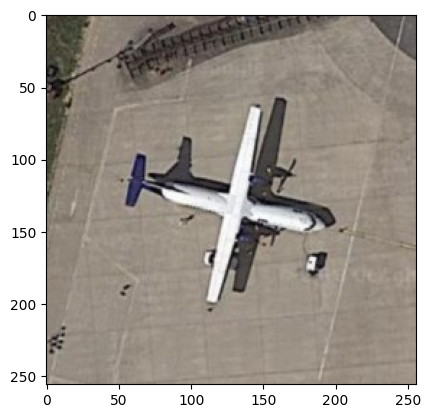

In [ ]:
img_name = aircraftType + "_test.jpg"
test_img = cv2.imread('gdrive/MyDrive/Project_DL/TestImages/' + img_name)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
plt.show()

Resize an image so it matches input layer form (256, 256)

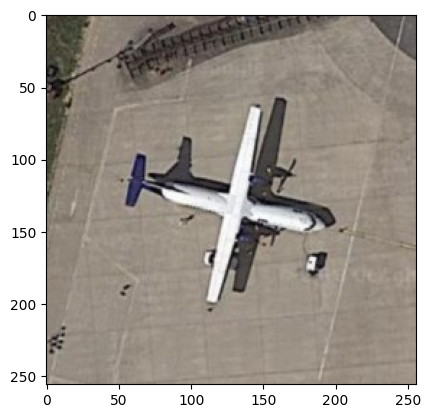

In [ ]:
resize = tf.image.resize(test_img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

Prediction!

In [ ]:
prediction = predictAircraft(np.expand_dims(resize/255, 0), model)
print(prediction)

1/1 [==============================] - 0s 20ms/step
This is a(an) ATR-72_Airliner, probability is 100.0%


# 8. Save the model

In [ ]:
model.save(os.path.join('/content/gdrive/MyDrive/', 'milAirClassifier.h5'))

Link to the model: https://drive.google.com/file/d/1oo7Iry0HD0A73zUNHxZKFETipR5fIs5H/view?usp=sharing

# 9. Conclusions

In conclusion, I can say that this project is half-successful. The performance looks quite good on plots, but it messes up with some planes when it comes to predicting. Why?

The main reason is dataset. There are 40 classes, but only 10 000 images, which I think is not really enough for such a big classification problem. (And dataset is unbalanced). There are many simillar aircraft classes as well, which even I can not normally distinct. Like atr72 airliner (civilian) and atr72asw (anti submarine warfare). Don't look on a hint below and try to guess which one is which :)

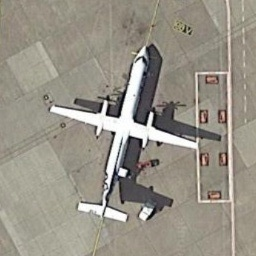

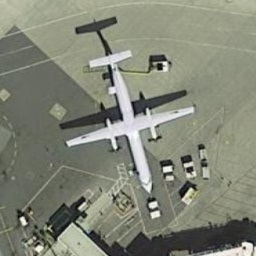

The first one has a livery on it's tail - it's civilian, second one doesn't - it's military.

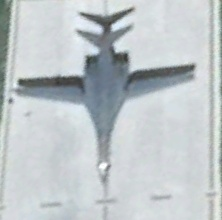



```
# 1/1 [==============================] - 0s 20ms/step
This is a(an) F-16_Falcon, probability is 54.4%
```
Model thought that this B-1 lancer is F-16


The other reasons are google colab limitations and maybe my own inexperience. While trying to train alexNet or VggaNet like model from lab 7 notebook crashed due to lack of RAM. ( + I used all of the colab GPU limits on 3 accounts ).

I believe there is a way to design and train better model, but this is the best result I've reached so far.

Anyway, I had some fun)

Useful videos:

https://www.youtube.com/watch?v=jztwpsIzEGc , from this video i took very cool idea with dataset_from_directory

https://www.youtube.com/watch?v=t0EzVCvQjGE&t ,good explanations